referensi https://www.kaggle.com/cast42/feature-selection-and-elastic-net

In [1]:
#libraries buat seleksi fitur
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from itertools import product
from sklearn.linear_model import ElasticNet

#libraries buat klasifikasi
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import time
import sys

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
#import dataset
df = pd.read_csv('nirsMangga.csv')

# separate dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(
    df.drop(labels=['No', 'Mango Cultivars', 'Vit C (mg/100g)', 'TA (mg/100g)', 'SSC (oBrix)', 'label'], axis=1),
    df['label'],
    test_size=0.3,
    random_state=0)

x_train.head()

,999.9,1000.3,1000.7,1001.1,1001.4,1001.8,1002.2,1002.6,1003,1003.4,...,2478.7,2481.1,2483.5,2485.8,2488.2,2490.6,2493,2495.4,2497.8,2500.2
16,0.471459,0.471074,0.470934,0.470379,0.470260,0.469880,0.469497,0.469435,0.469454,0.468998,...,1.413537,1.415740,1.417568,1.419698,1.421711,1.423070,1.424394,1.426121,1.427552,1.428625
51,0.433239,0.432622,0.432626,0.432379,0.431620,0.430710,0.430836,0.430847,0.430188,0.429470,...,1.601232,1.602877,1.604524,1.605982,1.606778,1.607837,1.608756,1.609967,1.610900,1.611099
183,0.545045,0.544204,0.543792,0.543596,0.543338,0.542534,0.541493,0.541139,0.541308,0.540831,...,1.524657,1.525973,1.527454,1.529518,1.530097,1.530315,1.530254,1.531191,1.532366,1.533183
145,0.545846,0.544815,0.544524,0.544631,0.544169,0.543143,0.542535,0.542080,0.541842,0.541258,...,1.421962,1.422955,1.423717,1.424639,1.425080,1.425797,1.426503,1.427164,1.427838,1.428271
40,0.381048,0.380483,0.380541,0.380151,0.379599,0.379189,0.379009,0.378722,0.378309,0.377719,...,1.571125,1.572674,1.574303,1.576075,1.577273,1.577980,1.578561,1.579334,1.580042,1.581424


# Seleksi Fitur Elastic Net

### Cari pasangan nilai alpha dan l1_ratio terbaik

In [41]:
%%time

#define fungsi buat ngitung rmse
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 22.6 µs


In [42]:
%%time

alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1]
l1_ratios = [0.5, 0.1, 1, 0.9, 0.8, 0.7, 0.5]

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 20.7 µs


In [43]:
%%time

#train beberapa model elastic net menggunakan pasangan alphas sm l1 ratio
cv_elastic = [rmse_cv(ElasticNet(alpha = alpha, l1_ratio=l1_ratio, tol=0.9)).mean()
              for (alpha, l1_ratio) in product(alphas, l1_ratios)]

CPU times: user 4min 45s, sys: 6min 41s, total: 11min 27s
Wall time: 39.9 s


Text(0, 0.5, 'rmse')

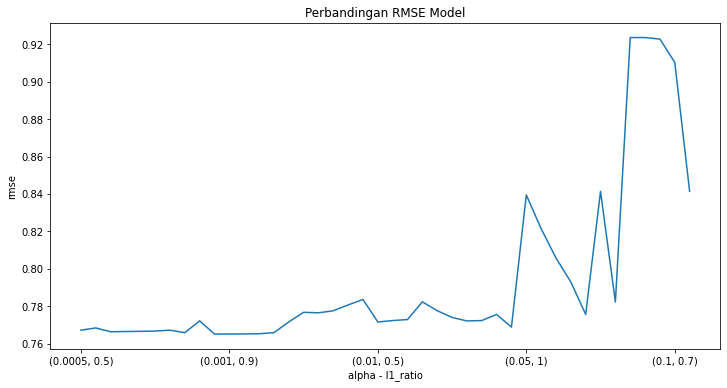

In [6]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))
p_cv_elastic = pd.Series(cv_elastic, index = idx)
p_cv_elastic.plot(title = "Perbandingan RMSE Model")
plt.xlabel("alpha - l1_ratio")
plt.ylabel("rmse")

Dapat dilihat bahwa pasangan nilai alpha sebesar 0.001 dan l1_ratio sebesar 0.9 mampu menghasilkan nilai RMSE terkecil (sekitar 0.76)

In [7]:
%%time
# bikin elastic net pake rmse paling kecil
elastic = ElasticNet(alpha=0.001, l1_ratio=0.9, tol=0.9)

In [8]:
%%time

elastic.fit(x_train, y_train)

CPU times: user 81.5 ms, sys: 114 ms, total: 195 ms
Wall time: 22.9 ms


ElasticNet(alpha=0.001, l1_ratio=0.9, tol=0.9)

In [9]:
#ambil koefisien dari model elastic
coef = pd.Series(elastic.coef_, index = x_train.columns)

In [10]:
coef

999.9    -3.785168
1000.3   -0.135855
1000.7   -0.028763
1001.1   -0.000000
1001.4   -0.000000
            ...   
2490.6   -0.000000
2493     -0.014332
2495.4   -0.004718
2497.8   -0.000000
2500.2   -0.003059
Length: 1557, dtype: float64

In [11]:
print("Elastic Net mengambil " + str(sum(coef != 0)) + " variabel dan menghilangkan " +  str(sum(coef == 0)) + " variabel")

Elastic Net mengambil 1009 variabel dan menghilangkan 548 variabel


In [12]:
#buat data frame yg nyimpan fitur terpilih beserta coef-nya
df_coef = pd.DataFrame(coef, columns=["Coeficients"])
df_fitur_terpilih = df_coef[(df_coef != 0).all(1)]

In [28]:
df_fitur_terpilih.nlargest(1009, columns="Coeficients")

,Coeficients
1135.2,0.109465
1136.7,0.097417
1138.7,0.095541
1877.4,0.093084
1878.8,0.089069
...,...
1906.4,-0.061061
1905,-0.065312
1912,-0.070134
1000.3,-0.135855


In [14]:
print("Fitur yang dipilih : " + str(df_fitur_terpilih.index.tolist()))
print("Total fitur yang dipilih : " + str(len(df_fitur_terpilih.index)))

Fitur yang dipilih : ['999.9', '1000.3', '1000.7', '1079.4', '1079.9', '1080.8', '1082.1', '1082.6', '1083.9', '1084.4', '1085.3', '1085.7', '1086.2', '1086.6', '1087.1', '1088.9', '1089.4', '1089.8', '1091.2', '1091.7', '1092.1', '1092.6', '1093.1', '1093.5', '1094', '1094.4', '1094.9', '1095.4', '1095.8', '1096.3', '1096.8', '1097.2', '1098.2', '1098.6', '1099.1', '1099.5', '1100', '1100.5', '1100.9', '1101.4', '1101.9', '1102.4', '1102.8', '1103.3', '1103.8', '1104.2', '1104.7', '1105.6', '1106.1', '1106.6', '1107.1', '1108.5', '1109', '1109.4', '1109.9', '1110.4', '1110.9', '1111.8', '1112.3', '1112.8', '1113.2', '1113.7', '1114.2', '1114.7', '1115.2', '1115.6', '1116.1', '1117.6', '1118', '1119', '1119.5', '1120', '1120.5', '1120.9', '1121.4', '1121.9', '1122.9', '1123.4', '1124.3', '1124.8', '1125.3', '1125.8', '1126.3', '1126.8', '1127.3', '1127.8', '1128.3', '1128.7', '1129.2', '1129.7', '1130.2', '1130.7', '1131.2', '1131.7', '1132.2', '1132.7', '1133.2', '1133.7', '1134.2', '

# Klasifikasi Random Forest Classifier

In [16]:
#buat n-fold cv
#cross validation 10-fold
cv = KFold(n_splits=10, random_state=1, shuffle=True)

## Testing Performa Model Random Forest Classifier

In [30]:
%%time

#tentukan metode scoring yang digunakan
scoring_rfe = {'acc': 'accuracy',
               'prec_micro': 'precision_micro',
               'rec_micro': 'recall_micro'}

#tentukan total fitur dan trees yang digunakan dalam proses klasifikasi ini
n_feat = range(1, 101)
n_trees = [100]

max_acc = 0
max_prec = 0
max_rec = 0


for nfeat in n_feat:
    for ntrees in n_trees:
        print("==================================================")
        start_time = time.time()
        
        #ambil n fitur input hasil seleksi fitur Elastic Net
        x_train_selected = x_train[df_fitur_terpilih.nlargest(1009, columns="Coeficients").iloc[0:nfeat, 0].index]
        x_test_selected = x_test[df_fitur_terpilih.nlargest(1009, columns="Coeficients").iloc[0:nfeat, 0].index]

        #Create a Gaussian Classifier
        clf_rfe = RandomForestClassifier(n_estimators=ntrees)
        
        #Train the model using the training sets
        clf_rfe.fit(x_train_selected, y_train)
        y_pred_rfe=clf_rfe.predict(x_test_selected)
        
        #hitung score model dari data train
        scores_rfe = cross_validate(clf_rfe, x_train_selected, y_train, scoring=scoring_rfe, cv=cv, return_train_score=True)
        
        print("Akurasi model RFE data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(scores_rfe['train_acc'].mean(), 2)))
        print("Akurasi model RFE data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(metrics.accuracy_score(y_test, y_pred_rfe), 2)))
        print("Precision model RFE data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(scores_rfe['train_prec_micro'].mean(), 2)))
        print("Precision model RFE data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(metrics.precision_score(y_test, y_pred_rfe, average='micro'), 2)))
        print("Recall model RFE data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(scores_rfe['train_rec_micro'].mean(), 2)))
        print("Recall model RFE data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(metrics.recall_score(y_test, y_pred_rfe, average='micro'), 2)))
        print(" ")
        
        if(round(metrics.accuracy_score(y_test, y_pred_rfe), 2) > max_acc):
            max_acc = round(metrics.accuracy_score(y_test, y_pred_rfe), 2)
        
        if(round(metrics.precision_score(y_test, y_pred_rfe, average='micro'), 2) > max_prec):
            max_prec = round(metrics.precision_score(y_test, y_pred_rfe, average='micro'), 2)
            
        if(round(metrics.recall_score(y_test, y_pred_rfe, average='micro'), 2) > max_rec):
            max_rec = round(metrics.recall_score(y_test, y_pred_rfe, average='micro'), 2)
            
        end_time = time.time()
        print("Total waktu: ", end_time - start_time)

print("====Nilai Performa Tertinggi====")
print("Nilai akurasi model tertinggi: " + str(max_acc))
print("Nilai presisi model tertinggi: " + str(max_prec))
print("Nilai Recall model tertinggi: " + str(max_rec))

Akurasi model RFE data Train dengan 1 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 1 fitur dan 100 trees:0.8
Precision model RFE data Train dengan 1 fitur dan 100 trees:1.0
Precision model RFE data Test dengan 1 fitur dan 100 trees:0.8
Recall model RFE data Train dengan 1 fitur dan 100 trees:1.0
Recall model RFE data Test dengan 1 fitur dan 100 trees:0.8
 
Total waktu:  1.358659029006958
Akurasi model RFE data Train dengan 2 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 2 fitur dan 100 trees:0.82
Precision model RFE data Train dengan 2 fitur dan 100 trees:1.0
Precision model RFE data Test dengan 2 fitur dan 100 trees:0.82
Recall model RFE data Train dengan 2 fitur dan 100 trees:1.0
Recall model RFE data Test dengan 2 fitur dan 100 trees:0.82
 
Total waktu:  1.2906825542449951
Akurasi model RFE data Train dengan 3 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 3 fitur dan 100 trees:0.84
Precision model RFE data Train dengan 3 fitur dan 100 trees:1.

Akurasi model RFE data Train dengan 19 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 19 fitur dan 100 trees:0.86
Precision model RFE data Train dengan 19 fitur dan 100 trees:1.0
Precision model RFE data Test dengan 19 fitur dan 100 trees:0.86
Recall model RFE data Train dengan 19 fitur dan 100 trees:1.0
Recall model RFE data Test dengan 19 fitur dan 100 trees:0.86
 
Total waktu:  1.295280933380127
Akurasi model RFE data Train dengan 20 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 20 fitur dan 100 trees:0.91
Precision model RFE data Train dengan 20 fitur dan 100 trees:1.0
Precision model RFE data Test dengan 20 fitur dan 100 trees:0.91
Recall model RFE data Train dengan 20 fitur dan 100 trees:1.0
Recall model RFE data Test dengan 20 fitur dan 100 trees:0.91
 
Total waktu:  1.297938346862793
Akurasi model RFE data Train dengan 21 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 21 fitur dan 100 trees:0.91
Precision model RFE data Train dengan 21 fitur

Akurasi model RFE data Train dengan 37 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 37 fitur dan 100 trees:0.88
Precision model RFE data Train dengan 37 fitur dan 100 trees:1.0
Precision model RFE data Test dengan 37 fitur dan 100 trees:0.88
Recall model RFE data Train dengan 37 fitur dan 100 trees:1.0
Recall model RFE data Test dengan 37 fitur dan 100 trees:0.88
 
Total waktu:  1.36562180519104
Akurasi model RFE data Train dengan 38 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 38 fitur dan 100 trees:0.88
Precision model RFE data Train dengan 38 fitur dan 100 trees:1.0
Precision model RFE data Test dengan 38 fitur dan 100 trees:0.88
Recall model RFE data Train dengan 38 fitur dan 100 trees:1.0
Recall model RFE data Test dengan 38 fitur dan 100 trees:0.88
 
Total waktu:  1.3576905727386475
Akurasi model RFE data Train dengan 39 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 39 fitur dan 100 trees:0.91
Precision model RFE data Train dengan 39 fitur

Akurasi model RFE data Train dengan 55 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 55 fitur dan 100 trees:0.95
Precision model RFE data Train dengan 55 fitur dan 100 trees:1.0
Precision model RFE data Test dengan 55 fitur dan 100 trees:0.95
Recall model RFE data Train dengan 55 fitur dan 100 trees:1.0
Recall model RFE data Test dengan 55 fitur dan 100 trees:0.95
 
Total waktu:  1.4015541076660156
Akurasi model RFE data Train dengan 56 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 56 fitur dan 100 trees:0.93
Precision model RFE data Train dengan 56 fitur dan 100 trees:1.0
Precision model RFE data Test dengan 56 fitur dan 100 trees:0.93
Recall model RFE data Train dengan 56 fitur dan 100 trees:1.0
Recall model RFE data Test dengan 56 fitur dan 100 trees:0.93
 
Total waktu:  1.4223172664642334
Akurasi model RFE data Train dengan 57 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 57 fitur dan 100 trees:0.93
Precision model RFE data Train dengan 57 fit

Akurasi model RFE data Train dengan 73 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 73 fitur dan 100 trees:0.95
Precision model RFE data Train dengan 73 fitur dan 100 trees:1.0
Precision model RFE data Test dengan 73 fitur dan 100 trees:0.95
Recall model RFE data Train dengan 73 fitur dan 100 trees:1.0
Recall model RFE data Test dengan 73 fitur dan 100 trees:0.95
 
Total waktu:  1.4172389507293701
Akurasi model RFE data Train dengan 74 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 74 fitur dan 100 trees:0.95
Precision model RFE data Train dengan 74 fitur dan 100 trees:1.0
Precision model RFE data Test dengan 74 fitur dan 100 trees:0.95
Recall model RFE data Train dengan 74 fitur dan 100 trees:1.0
Recall model RFE data Test dengan 74 fitur dan 100 trees:0.95
 
Total waktu:  1.3898985385894775
Akurasi model RFE data Train dengan 75 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 75 fitur dan 100 trees:0.91
Precision model RFE data Train dengan 75 fit

Akurasi model RFE data Train dengan 91 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 91 fitur dan 100 trees:0.95
Precision model RFE data Train dengan 91 fitur dan 100 trees:1.0
Precision model RFE data Test dengan 91 fitur dan 100 trees:0.95
Recall model RFE data Train dengan 91 fitur dan 100 trees:1.0
Recall model RFE data Test dengan 91 fitur dan 100 trees:0.95
 
Total waktu:  1.409247875213623
Akurasi model RFE data Train dengan 92 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 92 fitur dan 100 trees:0.95
Precision model RFE data Train dengan 92 fitur dan 100 trees:1.0
Precision model RFE data Test dengan 92 fitur dan 100 trees:0.95
Recall model RFE data Train dengan 92 fitur dan 100 trees:1.0
Recall model RFE data Test dengan 92 fitur dan 100 trees:0.95
 
Total waktu:  1.395650863647461
Akurasi model RFE data Train dengan 93 fitur dan 100 trees:1.0
Akurasi model RFE data Test dengan 93 fitur dan 100 trees:0.95
Precision model RFE data Train dengan 93 fitur

In [31]:
%%time

#tentukan metode scoring yang digunakan
scoring_rfe = {'acc': 'accuracy',
               'prec_micro': 'precision_micro',
               'rec_micro': 'recall_micro'}

#tentukan total fitur dan trees yang digunakan dalam proses klasifikasi ini
n_feat = range(1, 101)
n_trees = [150]

max_acc = 0
max_prec = 0
max_rec = 0


for nfeat in n_feat:
    for ntrees in n_trees:
        print("==================================================")
        start_time = time.time()
        
        #ambil n fitur input hasil seleksi fitur Elastic Net
        x_train_selected = x_train[df_fitur_terpilih.nlargest(1009, columns="Coeficients").iloc[0:nfeat, 0].index]
        x_test_selected = x_test[df_fitur_terpilih.nlargest(1009, columns="Coeficients").iloc[0:nfeat, 0].index]

        #Create a Gaussian Classifier
        clf_rfe = RandomForestClassifier(n_estimators=ntrees)
        
        #Train the model using the training sets
        clf_rfe.fit(x_train_selected, y_train)
        y_pred_rfe=clf_rfe.predict(x_test_selected)
        
        #hitung score model dari data train
        scores_rfe = cross_validate(clf_rfe, x_train_selected, y_train, scoring=scoring_rfe, cv=cv, return_train_score=True)
        
        print("Akurasi model RFE data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(scores_rfe['train_acc'].mean(), 2)))
        print("Akurasi model RFE data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(metrics.accuracy_score(y_test, y_pred_rfe), 2)))
        print("Precision model RFE data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(scores_rfe['train_prec_micro'].mean(), 2)))
        print("Precision model RFE data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(metrics.precision_score(y_test, y_pred_rfe, average='micro'), 2)))
        print("Recall model RFE data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(scores_rfe['train_rec_micro'].mean(), 2)))
        print("Recall model RFE data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(metrics.recall_score(y_test, y_pred_rfe, average='micro'), 2)))
        print(" ")
        
        if(round(metrics.accuracy_score(y_test, y_pred_rfe), 2) > max_acc):
            max_acc = round(metrics.accuracy_score(y_test, y_pred_rfe), 2)
        
        if(round(metrics.precision_score(y_test, y_pred_rfe, average='micro'), 2) > max_prec):
            max_prec = round(metrics.precision_score(y_test, y_pred_rfe, average='micro'), 2)
            
        if(round(metrics.recall_score(y_test, y_pred_rfe, average='micro'), 2) > max_rec):
            max_rec = round(metrics.recall_score(y_test, y_pred_rfe, average='micro'), 2)
            
        end_time = time.time()
        print("Total waktu: ", end_time - start_time)

print("====Nilai Performa Tertinggi====")
print("Nilai akurasi model tertinggi: " + str(max_acc))
print("Nilai presisi model tertinggi: " + str(max_prec))
print("Nilai Recall model tertinggi: " + str(max_rec))

Akurasi model RFE data Train dengan 1 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 1 fitur dan 150 trees:0.8
Precision model RFE data Train dengan 1 fitur dan 150 trees:1.0
Precision model RFE data Test dengan 1 fitur dan 150 trees:0.8
Recall model RFE data Train dengan 1 fitur dan 150 trees:1.0
Recall model RFE data Test dengan 1 fitur dan 150 trees:0.8
 
Total waktu:  1.9485673904418945
Akurasi model RFE data Train dengan 2 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 2 fitur dan 150 trees:0.82
Precision model RFE data Train dengan 2 fitur dan 150 trees:1.0
Precision model RFE data Test dengan 2 fitur dan 150 trees:0.82
Recall model RFE data Train dengan 2 fitur dan 150 trees:1.0
Recall model RFE data Test dengan 2 fitur dan 150 trees:0.82
 
Total waktu:  1.9549648761749268
Akurasi model RFE data Train dengan 3 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 3 fitur dan 150 trees:0.84
Precision model RFE data Train dengan 3 fitur dan 150 trees:1

Akurasi model RFE data Train dengan 19 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 19 fitur dan 150 trees:0.89
Precision model RFE data Train dengan 19 fitur dan 150 trees:1.0
Precision model RFE data Test dengan 19 fitur dan 150 trees:0.89
Recall model RFE data Train dengan 19 fitur dan 150 trees:1.0
Recall model RFE data Test dengan 19 fitur dan 150 trees:0.89
 
Total waktu:  1.9305202960968018
Akurasi model RFE data Train dengan 20 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 20 fitur dan 150 trees:0.86
Precision model RFE data Train dengan 20 fitur dan 150 trees:1.0
Precision model RFE data Test dengan 20 fitur dan 150 trees:0.86
Recall model RFE data Train dengan 20 fitur dan 150 trees:1.0
Recall model RFE data Test dengan 20 fitur dan 150 trees:0.86
 
Total waktu:  1.9323241710662842
Akurasi model RFE data Train dengan 21 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 21 fitur dan 150 trees:0.89
Precision model RFE data Train dengan 21 fit

Akurasi model RFE data Train dengan 37 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 37 fitur dan 150 trees:0.91
Precision model RFE data Train dengan 37 fitur dan 150 trees:1.0
Precision model RFE data Test dengan 37 fitur dan 150 trees:0.91
Recall model RFE data Train dengan 37 fitur dan 150 trees:1.0
Recall model RFE data Test dengan 37 fitur dan 150 trees:0.91
 
Total waktu:  1.9552090167999268
Akurasi model RFE data Train dengan 38 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 38 fitur dan 150 trees:0.91
Precision model RFE data Train dengan 38 fitur dan 150 trees:1.0
Precision model RFE data Test dengan 38 fitur dan 150 trees:0.91
Recall model RFE data Train dengan 38 fitur dan 150 trees:1.0
Recall model RFE data Test dengan 38 fitur dan 150 trees:0.91
 
Total waktu:  1.9439871311187744
Akurasi model RFE data Train dengan 39 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 39 fitur dan 150 trees:0.93
Precision model RFE data Train dengan 39 fit

Akurasi model RFE data Train dengan 55 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 55 fitur dan 150 trees:0.93
Precision model RFE data Train dengan 55 fitur dan 150 trees:1.0
Precision model RFE data Test dengan 55 fitur dan 150 trees:0.93
Recall model RFE data Train dengan 55 fitur dan 150 trees:1.0
Recall model RFE data Test dengan 55 fitur dan 150 trees:0.93
 
Total waktu:  2.011345148086548
Akurasi model RFE data Train dengan 56 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 56 fitur dan 150 trees:0.95
Precision model RFE data Train dengan 56 fitur dan 150 trees:1.0
Precision model RFE data Test dengan 56 fitur dan 150 trees:0.95
Recall model RFE data Train dengan 56 fitur dan 150 trees:1.0
Recall model RFE data Test dengan 56 fitur dan 150 trees:0.95
 
Total waktu:  1.9975674152374268
Akurasi model RFE data Train dengan 57 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 57 fitur dan 150 trees:0.91
Precision model RFE data Train dengan 57 fitu

Akurasi model RFE data Train dengan 73 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 73 fitur dan 150 trees:0.95
Precision model RFE data Train dengan 73 fitur dan 150 trees:1.0
Precision model RFE data Test dengan 73 fitur dan 150 trees:0.95
Recall model RFE data Train dengan 73 fitur dan 150 trees:1.0
Recall model RFE data Test dengan 73 fitur dan 150 trees:0.95
 
Total waktu:  2.052910327911377
Akurasi model RFE data Train dengan 74 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 74 fitur dan 150 trees:0.95
Precision model RFE data Train dengan 74 fitur dan 150 trees:1.0
Precision model RFE data Test dengan 74 fitur dan 150 trees:0.95
Recall model RFE data Train dengan 74 fitur dan 150 trees:1.0
Recall model RFE data Test dengan 74 fitur dan 150 trees:0.95
 
Total waktu:  2.0380136966705322
Akurasi model RFE data Train dengan 75 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 75 fitur dan 150 trees:0.93
Precision model RFE data Train dengan 75 fitu

Akurasi model RFE data Train dengan 91 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 91 fitur dan 150 trees:0.95
Precision model RFE data Train dengan 91 fitur dan 150 trees:1.0
Precision model RFE data Test dengan 91 fitur dan 150 trees:0.95
Recall model RFE data Train dengan 91 fitur dan 150 trees:1.0
Recall model RFE data Test dengan 91 fitur dan 150 trees:0.95
 
Total waktu:  2.105515241622925
Akurasi model RFE data Train dengan 92 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 92 fitur dan 150 trees:0.95
Precision model RFE data Train dengan 92 fitur dan 150 trees:1.0
Precision model RFE data Test dengan 92 fitur dan 150 trees:0.95
Recall model RFE data Train dengan 92 fitur dan 150 trees:1.0
Recall model RFE data Test dengan 92 fitur dan 150 trees:0.95
 
Total waktu:  2.0725724697113037
Akurasi model RFE data Train dengan 93 fitur dan 150 trees:1.0
Akurasi model RFE data Test dengan 93 fitur dan 150 trees:0.95
Precision model RFE data Train dengan 93 fitu

In [32]:
%%time

#tentukan metode scoring yang digunakan
scoring_rfe = {'acc': 'accuracy',
               'prec_micro': 'precision_micro',
               'rec_micro': 'recall_micro'}

#tentukan total fitur dan trees yang digunakan dalam proses klasifikasi ini
n_feat = range(1, 101)
n_trees = [200]

max_acc = 0
max_prec = 0
max_rec = 0


for nfeat in n_feat:
    for ntrees in n_trees:
        print("==================================================")
        start_time = time.time()
        
        #ambil n fitur input hasil seleksi fitur Elastic Net
        x_train_selected = x_train[df_fitur_terpilih.nlargest(1009, columns="Coeficients").iloc[0:nfeat, 0].index]
        x_test_selected = x_test[df_fitur_terpilih.nlargest(1009, columns="Coeficients").iloc[0:nfeat, 0].index]

        #Create a Gaussian Classifier
        clf_rfe = RandomForestClassifier(n_estimators=ntrees)
        
        #Train the model using the training sets
        clf_rfe.fit(x_train_selected, y_train)
        y_pred_rfe=clf_rfe.predict(x_test_selected)
        
        #hitung score model dari data train
        scores_rfe = cross_validate(clf_rfe, x_train_selected, y_train, scoring=scoring_rfe, cv=cv, return_train_score=True)
        
        print("Akurasi model RFE data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(scores_rfe['train_acc'].mean(), 2)))
        print("Akurasi model RFE data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(metrics.accuracy_score(y_test, y_pred_rfe), 2)))
        print("Precision model RFE data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(scores_rfe['train_prec_micro'].mean(), 2)))
        print("Precision model RFE data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(metrics.precision_score(y_test, y_pred_rfe, average='micro'), 2)))
        print("Recall model RFE data Train dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(scores_rfe['train_rec_micro'].mean(), 2)))
        print("Recall model RFE data Test dengan " + str(nfeat) + " fitur dan " + str(ntrees) + " trees:" 
              + str(round(metrics.recall_score(y_test, y_pred_rfe, average='micro'), 2)))
        print(" ")
        
        if(round(metrics.accuracy_score(y_test, y_pred_rfe), 2) > max_acc):
            max_acc = round(metrics.accuracy_score(y_test, y_pred_rfe), 2)
        
        if(round(metrics.precision_score(y_test, y_pred_rfe, average='micro'), 2) > max_prec):
            max_prec = round(metrics.precision_score(y_test, y_pred_rfe, average='micro'), 2)
            
        if(round(metrics.recall_score(y_test, y_pred_rfe, average='micro'), 2) > max_rec):
            max_rec = round(metrics.recall_score(y_test, y_pred_rfe, average='micro'), 2)
            
        end_time = time.time()
        print("Total waktu: ", end_time - start_time)

print("====Nilai Performa Tertinggi====")
print("Nilai akurasi model tertinggi: " + str(max_acc))
print("Nilai presisi model tertinggi: " + str(max_prec))
print("Nilai Recall model tertinggi: " + str(max_rec))

Akurasi model RFE data Train dengan 1 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 1 fitur dan 200 trees:0.8
Precision model RFE data Train dengan 1 fitur dan 200 trees:1.0
Precision model RFE data Test dengan 1 fitur dan 200 trees:0.8
Recall model RFE data Train dengan 1 fitur dan 200 trees:1.0
Recall model RFE data Test dengan 1 fitur dan 200 trees:0.8
 
Total waktu:  2.407827615737915
Akurasi model RFE data Train dengan 2 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 2 fitur dan 200 trees:0.82
Precision model RFE data Train dengan 2 fitur dan 200 trees:1.0
Precision model RFE data Test dengan 2 fitur dan 200 trees:0.82
Recall model RFE data Train dengan 2 fitur dan 200 trees:1.0
Recall model RFE data Test dengan 2 fitur dan 200 trees:0.82
 
Total waktu:  2.3882901668548584
Akurasi model RFE data Train dengan 3 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 3 fitur dan 200 trees:0.84
Precision model RFE data Train dengan 3 fitur dan 200 trees:1.

Akurasi model RFE data Train dengan 19 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 19 fitur dan 200 trees:0.86
Precision model RFE data Train dengan 19 fitur dan 200 trees:1.0
Precision model RFE data Test dengan 19 fitur dan 200 trees:0.86
Recall model RFE data Train dengan 19 fitur dan 200 trees:1.0
Recall model RFE data Test dengan 19 fitur dan 200 trees:0.86
 
Total waktu:  2.571129560470581
Akurasi model RFE data Train dengan 20 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 20 fitur dan 200 trees:0.89
Precision model RFE data Train dengan 20 fitur dan 200 trees:1.0
Precision model RFE data Test dengan 20 fitur dan 200 trees:0.89
Recall model RFE data Train dengan 20 fitur dan 200 trees:1.0
Recall model RFE data Test dengan 20 fitur dan 200 trees:0.89
 
Total waktu:  2.578544855117798
Akurasi model RFE data Train dengan 21 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 21 fitur dan 200 trees:0.88
Precision model RFE data Train dengan 21 fitur

Akurasi model RFE data Train dengan 37 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 37 fitur dan 200 trees:0.91
Precision model RFE data Train dengan 37 fitur dan 200 trees:1.0
Precision model RFE data Test dengan 37 fitur dan 200 trees:0.91
Recall model RFE data Train dengan 37 fitur dan 200 trees:1.0
Recall model RFE data Test dengan 37 fitur dan 200 trees:0.91
 
Total waktu:  2.7317607402801514
Akurasi model RFE data Train dengan 38 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 38 fitur dan 200 trees:0.89
Precision model RFE data Train dengan 38 fitur dan 200 trees:1.0
Precision model RFE data Test dengan 38 fitur dan 200 trees:0.89
Recall model RFE data Train dengan 38 fitur dan 200 trees:1.0
Recall model RFE data Test dengan 38 fitur dan 200 trees:0.89
 
Total waktu:  2.698601484298706
Akurasi model RFE data Train dengan 39 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 39 fitur dan 200 trees:0.91
Precision model RFE data Train dengan 39 fitu

Akurasi model RFE data Train dengan 55 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 55 fitur dan 200 trees:0.95
Precision model RFE data Train dengan 55 fitur dan 200 trees:1.0
Precision model RFE data Test dengan 55 fitur dan 200 trees:0.95
Recall model RFE data Train dengan 55 fitur dan 200 trees:1.0
Recall model RFE data Test dengan 55 fitur dan 200 trees:0.95
 
Total waktu:  2.661468744277954
Akurasi model RFE data Train dengan 56 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 56 fitur dan 200 trees:0.93
Precision model RFE data Train dengan 56 fitur dan 200 trees:1.0
Precision model RFE data Test dengan 56 fitur dan 200 trees:0.93
Recall model RFE data Train dengan 56 fitur dan 200 trees:1.0
Recall model RFE data Test dengan 56 fitur dan 200 trees:0.93
 
Total waktu:  2.7209296226501465
Akurasi model RFE data Train dengan 57 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 57 fitur dan 200 trees:0.95
Precision model RFE data Train dengan 57 fitu

Akurasi model RFE data Train dengan 73 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 73 fitur dan 200 trees:0.95
Precision model RFE data Train dengan 73 fitur dan 200 trees:1.0
Precision model RFE data Test dengan 73 fitur dan 200 trees:0.95
Recall model RFE data Train dengan 73 fitur dan 200 trees:1.0
Recall model RFE data Test dengan 73 fitur dan 200 trees:0.95
 
Total waktu:  2.6570122241973877
Akurasi model RFE data Train dengan 74 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 74 fitur dan 200 trees:0.95
Precision model RFE data Train dengan 74 fitur dan 200 trees:1.0
Precision model RFE data Test dengan 74 fitur dan 200 trees:0.95
Recall model RFE data Train dengan 74 fitur dan 200 trees:1.0
Recall model RFE data Test dengan 74 fitur dan 200 trees:0.95
 
Total waktu:  2.6984386444091797
Akurasi model RFE data Train dengan 75 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 75 fitur dan 200 trees:0.95
Precision model RFE data Train dengan 75 fit

Akurasi model RFE data Train dengan 91 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 91 fitur dan 200 trees:0.95
Precision model RFE data Train dengan 91 fitur dan 200 trees:1.0
Precision model RFE data Test dengan 91 fitur dan 200 trees:0.95
Recall model RFE data Train dengan 91 fitur dan 200 trees:1.0
Recall model RFE data Test dengan 91 fitur dan 200 trees:0.95
 
Total waktu:  2.753901958465576
Akurasi model RFE data Train dengan 92 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 92 fitur dan 200 trees:0.95
Precision model RFE data Train dengan 92 fitur dan 200 trees:1.0
Precision model RFE data Test dengan 92 fitur dan 200 trees:0.95
Recall model RFE data Train dengan 92 fitur dan 200 trees:1.0
Recall model RFE data Test dengan 92 fitur dan 200 trees:0.95
 
Total waktu:  2.7283756732940674
Akurasi model RFE data Train dengan 93 fitur dan 200 trees:1.0
Akurasi model RFE data Test dengan 93 fitur dan 200 trees:0.95
Precision model RFE data Train dengan 93 fitu

# Klasifikasi Support Vector Machine

Untuk train dan test set, serta cv-nya ambil dari yang Random Forest Classifier, sama aja 

## Testing Performa Model Support Vector Machine

In [47]:
%%time

#tentukan metode scoring yang digunakan
scoring_svm = {'acc': 'accuracy',
               'prec_micro': 'precision_micro',
               'rec_micro': 'recall_micro'}

#tentukan total fitur dan trees yang digunakan dalam proses klasifikasi ini
n_feat = range(1, 101)


max_acc = 0
max_prec = 0
max_rec = 0


for nfeat in n_feat:
    print("==================================================")
    start_time = time.time()

    #ambil n fitur input hasil seleksi fitur Elastic Net
    x_train_selected = x_train[df_fitur_terpilih.nlargest(1009, columns="Coeficients").iloc[0:nfeat, 0].index]
    x_test_selected = x_test[df_fitur_terpilih.nlargest(1009, columns="Coeficients").iloc[0:nfeat, 0].index]

    #Create a Support Vector Classifier
    clf_svm = svm.SVC()

    #Train the model using the training sets
    clf_svm.fit(x_train_selected, y_train)
    y_pred_svm=clf_svm.predict(x_test_selected)

    #hitung score model dari data train
    scores_svm = cross_validate(clf_svm, x_train_selected, y_train, scoring=scoring_svm, cv=cv, return_train_score=True)

    print("akurasi model SVM data Train dengan " + str(nfeat) + " fitur: " 
          + str(round(scores_svm['train_acc'].mean(), 2)))
    print("akurasi model SVM data Test dengan " + str(nfeat) + " fitur: " 
          + str(round(metrics.accuracy_score(y_test, y_pred_svm), 2)))
    print("Precision model SVM data Train dengan " + str(nfeat) + " fitur:"
          + str(round(scores_svm['train_prec_micro'].mean(), 2)))
    print("Precision model SVM data Test dengan " + str(nfeat) + " fitur:"
          + str(round(metrics.precision_score(y_test, y_pred_svm, average='micro'), 2)))
    print("Recall model SVM data Train dengan " + str(nfeat) + " fitur:"
          + str(round(scores_svm['train_rec_micro'].mean(), 2)))
    print("Recall model SVM data Test dengan " + str(nfeat) + " fitur:"
          + str(round(metrics.recall_score(y_test, y_pred_svm, average='micro'), 2)))
    print(" ")


    if(round(metrics.accuracy_score(y_test, y_pred_svm), 2) > max_acc):
        max_acc = round(metrics.accuracy_score(y_test, y_pred_svm), 2)

    if(round(metrics.precision_score(y_test, y_pred_svm, average='micro'), 2) > max_prec):
        max_prec = round(metrics.precision_score(y_test, y_pred_svm, average='micro'), 2)

    if(round(metrics.recall_score(y_test, y_pred_svm, average='micro'), 2) > max_rec):
        max_rec = round(metrics.recall_score(y_test, y_pred_svm, average='micro'), 2)

    end_time = time.time()
    print("Total waktu: ", end_time - start_time)

print("====Nilai Performa Tertinggi====")
print("Nilai akurasi model tertinggi: " + str(max_acc))
print("Nilai presisi model tertinggi: " + str(max_prec))
print("Nilai Recall model tertinggi: " + str(max_rec))

akurasi model SVM data Train dengan 1 fitur: 0.71
akurasi model SVM data Test dengan 1 fitur: 0.66
Precision model SVM data Train dengan 1 fitur:0.71
Precision model SVM data Test dengan 1 fitur:0.66
Recall model SVM data Train dengan 1 fitur:0.71
Recall model SVM data Test dengan 1 fitur:0.66
 
Total waktu:  0.10955429077148438
akurasi model SVM data Train dengan 2 fitur: 0.71
akurasi model SVM data Test dengan 2 fitur: 0.66
Precision model SVM data Train dengan 2 fitur:0.71
Precision model SVM data Test dengan 2 fitur:0.66
Recall model SVM data Train dengan 2 fitur:0.71
Recall model SVM data Test dengan 2 fitur:0.66
 
Total waktu:  0.09863448143005371
akurasi model SVM data Train dengan 3 fitur: 0.71
akurasi model SVM data Test dengan 3 fitur: 0.64
Precision model SVM data Train dengan 3 fitur:0.71
Precision model SVM data Test dengan 3 fitur:0.64
Recall model SVM data Train dengan 3 fitur:0.71
Recall model SVM data Test dengan 3 fitur:0.64
 
Total waktu:  0.09404659271240234
akurasi

akurasi model SVM data Train dengan 23 fitur: 0.58
akurasi model SVM data Test dengan 23 fitur: 0.46
Precision model SVM data Train dengan 23 fitur:0.58
Precision model SVM data Test dengan 23 fitur:0.46
Recall model SVM data Train dengan 23 fitur:0.58
Recall model SVM data Test dengan 23 fitur:0.46
 
Total waktu:  0.27161407470703125
akurasi model SVM data Train dengan 24 fitur: 0.58
akurasi model SVM data Test dengan 24 fitur: 0.46
Precision model SVM data Train dengan 24 fitur:0.58
Precision model SVM data Test dengan 24 fitur:0.46
Recall model SVM data Train dengan 24 fitur:0.58
Recall model SVM data Test dengan 24 fitur:0.46
 
Total waktu:  0.23372364044189453
akurasi model SVM data Train dengan 25 fitur: 0.58
akurasi model SVM data Test dengan 25 fitur: 0.46
Precision model SVM data Train dengan 25 fitur:0.58
Precision model SVM data Test dengan 25 fitur:0.46
Recall model SVM data Train dengan 25 fitur:0.58
Recall model SVM data Test dengan 25 fitur:0.46
 
Total waktu:  0.2073566

akurasi model SVM data Train dengan 45 fitur: 0.6
akurasi model SVM data Test dengan 45 fitur: 0.55
Precision model SVM data Train dengan 45 fitur:0.6
Precision model SVM data Test dengan 45 fitur:0.55
Recall model SVM data Train dengan 45 fitur:0.6
Recall model SVM data Test dengan 45 fitur:0.55
 
Total waktu:  0.16839146614074707
akurasi model SVM data Train dengan 46 fitur: 0.6
akurasi model SVM data Test dengan 46 fitur: 0.55
Precision model SVM data Train dengan 46 fitur:0.6
Precision model SVM data Test dengan 46 fitur:0.55
Recall model SVM data Train dengan 46 fitur:0.6
Recall model SVM data Test dengan 46 fitur:0.55
 
Total waktu:  0.20719408988952637
akurasi model SVM data Train dengan 47 fitur: 0.61
akurasi model SVM data Test dengan 47 fitur: 0.55
Precision model SVM data Train dengan 47 fitur:0.61
Precision model SVM data Test dengan 47 fitur:0.55
Recall model SVM data Train dengan 47 fitur:0.61
Recall model SVM data Test dengan 47 fitur:0.55
 
Total waktu:  0.3680348396301

akurasi model SVM data Train dengan 68 fitur: 0.71
akurasi model SVM data Test dengan 68 fitur: 0.57
Precision model SVM data Train dengan 68 fitur:0.71
Precision model SVM data Test dengan 68 fitur:0.57
Recall model SVM data Train dengan 68 fitur:0.71
Recall model SVM data Test dengan 68 fitur:0.57
 
Total waktu:  0.13931488990783691
akurasi model SVM data Train dengan 69 fitur: 0.71
akurasi model SVM data Test dengan 69 fitur: 0.57
Precision model SVM data Train dengan 69 fitur:0.71
Precision model SVM data Test dengan 69 fitur:0.57
Recall model SVM data Train dengan 69 fitur:0.71
Recall model SVM data Test dengan 69 fitur:0.57
 
Total waktu:  0.1538221836090088
akurasi model SVM data Train dengan 70 fitur: 0.69
akurasi model SVM data Test dengan 70 fitur: 0.55
Precision model SVM data Train dengan 70 fitur:0.69
Precision model SVM data Test dengan 70 fitur:0.55
Recall model SVM data Train dengan 70 fitur:0.69
Recall model SVM data Test dengan 70 fitur:0.55
 
Total waktu:  0.14763998

akurasi model SVM data Train dengan 90 fitur: 0.73
akurasi model SVM data Test dengan 90 fitur: 0.55
Precision model SVM data Train dengan 90 fitur:0.73
Precision model SVM data Test dengan 90 fitur:0.55
Recall model SVM data Train dengan 90 fitur:0.73
Recall model SVM data Test dengan 90 fitur:0.55
 
Total waktu:  0.31952333450317383
akurasi model SVM data Train dengan 91 fitur: 0.73
akurasi model SVM data Test dengan 91 fitur: 0.55
Precision model SVM data Train dengan 91 fitur:0.73
Precision model SVM data Test dengan 91 fitur:0.55
Recall model SVM data Train dengan 91 fitur:0.73
Recall model SVM data Test dengan 91 fitur:0.55
 
Total waktu:  0.30583858489990234
akurasi model SVM data Train dengan 92 fitur: 0.73
akurasi model SVM data Test dengan 92 fitur: 0.57
Precision model SVM data Train dengan 92 fitur:0.73
Precision model SVM data Test dengan 92 fitur:0.57
Recall model SVM data Train dengan 92 fitur:0.73
Recall model SVM data Test dengan 92 fitur:0.57
 
Total waktu:  0.3256318

# Misc

In [ ]:
# Zoom in to the first 10 parameter pairs
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))[:10]
p_cv_elastic = pd.Series(cv_elastic[:10], index = idx)
p_cv_elastic.plot(title = "Perbandingan RMSE Model")
plt.xlabel("alpha - l1_ratio")
plt.ylabel("rmse")

In [ ]:
#n fitur terpenting
feat_selected = coef.sort_values(ascending=True).tail(6)
feat_selected

In [ ]:
feat_selected.index

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Koefisien setiap fitur dalam model Elastic Net")

Berdasarkan grafik di atas, dapat dilihat bahwa fitur '1254.3' merupakan fitur terpenting dari dataset.

Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

In [ ]:
feat_selected = coef.sort_values(ascending=False)
feat_selected